In [1]:
import rasterio
import numpy as np
from numpy import median
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
from sklearn import linear_model
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as multi
import seaborn as sns
# import holoviews as hv
# exploer datashader
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

import io
from scipy import misc
#import graphviz

 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
%matplotlib inline


C:\Users\mehdi\.conda\envs\geospatial\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Reading Data

In [2]:
driveName=r'D:\NLCD_Assessment'

In [3]:
#[cityName,addressFile,Datasource, Ecozone, AveHighTemp,AveLowTemp, AvePrecip]
# https://www.usclimatedata.com/climate/seattle/washington/united-states/uswa0395
cities=[
        ['Baltimore County, MD',r'{}\address'.format(driveName),'UV','8.3',19.1,10.3,1034],
        ['New York, NY',r'{}\address'.format(driveName),'UV','8.1',16.8,8.9,1174,121],
        ['Washington, DC',r'{}\address'.format(driveName),'UV','8.3',18.2,8.1,1036],
        ['Annapolis, MD',r'{}\address'.format(driveName),'UV','8.3',19.9,10,1202],
        ['Anne Arunde County, MD',r'{}\address'.format(driveName),'UV','8.3',19.9,10,1202],
        ['Denver, CO',r'{}\address'.format(driveName),'UV','9.4',18,2.4,360],
        ['Hardford County, MD',r'{}\address'.format(driveName),'UV','8.3',17.9,7.9,1139],
        ['Howard County, MD',r'{}\address'.format(driveName),'UV','8.3',19.1,5.7,1101],
        ['Jefferson County, WV',r'{}\address'.format(driveName),'UV','8.4',17.5,5.8,983],
        ['Montgomery County, MD',r'{}\address'.format(driveName),'UV','8.3',18.2,8.1,1036],
        ['Kenton County, KY',r'{}\address'.format(driveName),'UV','8.3',18.2,6.9,1073],
        ['Philadelphia, PA',r'{}\address'.format(driveName),'UV','8.3',18.1,8.4,1053],
        ['Pittsburgh, PA',r'{}\address'.format(driveName),'UV','8.4',16.3,5.9,884],
        ['Syracuse, NY',r'{}\address'.format(driveName),'UV','8.1',14.3,4.5,1055],
        ['Wicomico County, MD',r'{}\address'.format(driveName),'UV','8.5',18.9,7.7,1160],
        ['Cambridge, MA',r'{}\address'.format(driveName),'UV','8.1',14.8,6.7,1106],
        ['Boise, ID',r'{}\address'.format(driveName),'UV','10.1',17.5,5.1,294],
        ['Birmingham, AL',r'{}\address'.format(driveName),'EPA','8.4',23.2,11.5,1364],
        ['Austin, TX',r'{}\address'.format(driveName),'EPA','9.4',26.5,15,870],
        ['Chicago, IL',r'{}\address'.format(driveName),'EPA','8.2',15.2,6.3,991],
        ['Cleveland, OH',r'{}\address'.format(driveName),'EPA','8.1',15.3,6.2,994],
        ['Fresno, CA',r'{}\address'.format(driveName),'EPA','11.1',25,10.8, 326],
        ['Phoenix, AZ',r'{}\address'.format(driveName),'EPA','10.2',30.3,17.4,204],
        ['Memphis, TN',r'{}\address'.format(driveName),'EPA','8.3',22.4,12,1363],
        ['Milwaukee, WI',r'{}\address'.format(driveName),'EPA','8.2',13.1,4.4,876],
        ['Portland, OR',r'{}\address'.format(driveName),'EPA','7.1',17.3,7.6,914],
        ['Seattle, WA',r'{}\address'.format(driveName),'CitySeattle','7.1',14.8,7.2,952]
        ]
len(cities[0])

7

# (SI Section 1) Compiling dataframes

In [4]:
frames = []
corrolations=[]
for pair in cities:
    cityName=pair[0]
    print (cityName)
    adrMainFolder=pair[1]
    dataSource=pair[2]
    EcoRegions=pair[3]
    AveHighTemp = pair[4]
    AveLowTemp = pair[5]
    AvePrecip = pair[6]
    # get the input rasters
    adrNLCD_TC         =adrMainFolder+r'\nlcd_tc.tif'
    adrNLCD_TreeEror   =adrMainFolder+r'\nlcd_tree_error.tif'
    adrNLCDImp         =adrMainFolder+r'\nlcd_imp.tif'
    adrMorph           =adrMainFolder+r'\motype.tif'
    adrLandcover_tree  =adrMainFolder+r'\landcover_tree.tif'
    adrLandcover_imp   =adrMainFolder+r'\landcover_imp.tif'
    adrBldgSum         =adrMainFolder+r'\bldgSum.tif'
    adrBldgCount       =adrMainFolder+r'\bldgCount.tif'
    adrBldgAve         =adrMainFolder+r'\bldgAve.tif'
    adrNDVI            =adrMainFolder+r'\ndvi.tif'
    adrST              =adrMainFolder+r'\st.tif'
    adrNLCD_LC         =adrMainFolder+r'\nlcd_lc.tif'
    adrNodata          =adrMainFolder+r'\nodata.tif'
    adrMedYear         =adrMainFolder+r'\medYear.tif'
    adrNLCD_2019Ed     =adrMainFolder+r'\nlcd_tc_2011_2019Edition.tif'
    # get the rasters
    
    with rasterio.open(adrNLCD_TC,"r") as rstNLCD_TC:
        arNLCD_TC          = (rstNLCD_TC.read(1)).flatten()
        arNLCD_TC[arNLCD_TC==(rstNLCD_TC.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrNLCD_TreeEror,"r") as rstNLCD_TreeEror:
        arNLCD_TreeEror    = (rstNLCD_TreeEror.read(1)).flatten()
        arNLCD_TreeEror[arNLCD_TreeEror==(rstNLCD_TreeEror.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrNLCDImp,"r") as rstNLCDImp:
        arNLCDImp          = (rstNLCDImp.read(1)).flatten()
        arNLCDImp[arNLCDImp==(rstNLCDImp.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrMorph,"r") as rstMorph:
        arMorph            = (rstMorph.read(1)).flatten()
        arMorph[arMorph==(rstMorph.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrLandcover_tree,"r") as rstLandcover_tree:
        arLandcover_tree   = (rstLandcover_tree.read(1)).flatten()
        arLandcover_tree[arLandcover_tree==(rstLandcover_tree.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrLandcover_imp,"r") as rstLandcover_imp:
        arLandcover_imp    = (rstLandcover_imp.read(1)).flatten()
        arLandcover_imp[arLandcover_imp==(rstLandcover_imp.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrBldgSum,"r")  as rstBldgSum:
        arBldgSum          = (rstBldgSum.read(1)).flatten()
        arBldgSum[arBldgSum==(rstBldgSum.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrBldgCount,'r') as rstBldgCount:
        arBldgCount        = (rstBldgCount.read(1)).flatten()
        arBldgCount[arBldgCount==(rstBldgCount.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrBldgAve,"r") as rstBldgAve:
        arBldgAve          = (rstBldgAve.read(1)).flatten()
        arBldgAve[arBldgAve==(rstBldgAve.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrNDVI,'r') as rstNDVI:
        arNDVI             = (rstNDVI.read(1)).flatten()
        arNDVI[arNDVI==(rstNDVI.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrST,'r') as rstST:
        arST               = (rstST.read(1)).flatten()
        arST[arST==(rstST.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrNLCD_LC,'r') as rstNLCD_LC:
        arNLCD_LC           = (rstNLCD_LC.read(1)).flatten()
        arNLCD_LC[arNLCD_LC==(rstNLCD_LC.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrNodata,'r') as rstNodata:
        arNodata            = (rstNodata.read(1)).flatten()
        arNodata[arNodata==(rstNodata.meta.copy()['nodata'])]=-999
        
    with rasterio.open(adrMedYear,'r') as rstMedYear:
        arMedYear           = (rstMedYear.read(1)).flatten()
        arMedYear[arMedYear==(rstMedYear.meta.copy()['nodata'])]=-999
        
    with   rasterio.open(adrNLCD_2019Ed) as rstNLCD_2019Ed:
        arNLCD_2019Ed              = (rstNLCD_2019Ed.read(1)).flatten()
        arNLCD_2019Ed[arNLCD_2019Ed==(rstNLCD_2019Ed.meta.copy()['nodata'])]=-999
              
    
   
    dataIndex      =np.where((arNLCD_TC!=-999)&(arNLCDImp!=-999)&(arMorph!=-999)&
                               (arLandcover_tree!=-999)&(arLandcover_imp!=-999)&(arBldgSum!=-999)&
                               (arBldgCount!=-999)&(arBldgAve!=-999)&(arNDVI!=-999)&(arST!=-999)&(arNodata!=-999)&(arNLCD_2019Ed<=100))
    
   
    # with morphology layer
    #dataIndex = np.where((arLandcover_tree>0) & (arBldgSum>0) & (arLandcover_imp>0) & (arNLCD_TC>0) & (arMorph>0))
    
    
    # get the arrays
    arNLCD_TC         = (np.take(arNLCD_TC,dataIndex)).transpose()
    arNLCD_TreeEror   = (np.take(arNLCD_TreeEror,dataIndex)).transpose()
    arNLCDImp         = (np.take(arNLCDImp,dataIndex)).transpose()
    arLandcover_tree  = (np.take(arLandcover_tree,dataIndex)/9).transpose()
    arLandcover_imp   = (np.take(arLandcover_imp,dataIndex)/9).transpose()
    arBldgSum         = (np.take(arBldgSum,dataIndex)/9).transpose()
    arBldgCount       = (np.take(arBldgCount,dataIndex)).transpose()
    arBldgAve         = (np.take(arBldgAve,dataIndex)).transpose()
    arMorph           = ((np.take(arMorph,dataIndex)).astype(int)).transpose()
    arNDVI            = ((np.take(arNDVI,dataIndex))).transpose()
    arST              = ((np.take(arST,dataIndex))/100).transpose()
    arNLCD_LC         = ((np.take(arNLCD_LC,dataIndex)).astype(int)).transpose()
    arNodata          = ((np.take(arNodata,dataIndex)).astype(int)).transpose()
    arMedYear         = ((np.take(arMedYear,dataIndex)).astype(int)).transpose()
    arNLCD_2019Ed     = ((np.take(arNLCD_2019Ed,dataIndex)).astype(int)).transpose()
    #print((arLandcover_tree-arNLCD_2019Ed).mean())


    

    
    
    allArrays=np.hstack((arNLCD_TC, arNLCD_2019Ed, arNLCD_TreeEror, arNLCDImp,arLandcover_tree,
                         arLandcover_imp,arBldgSum,arBldgCount,arBldgAve,arMorph,arNDVI,arST,arNLCD_LC,arNodata,arMedYear))
   
    #allArrays=np.hstack((arNLCD_TC, arNLCD_TreeEror, arNLCDImp,arLandcover_tree,arLandcover_imp,arBldgSum,arMorph))
    
    #df = pd.DataFrame(allArrays,columns=['NLCD_TC','NLCD_TE','NLCD_imp','LC_Tree','LC_imp','bldgSum','morph'])
    df = pd.DataFrame(allArrays,columns=['NLCD_TC','NLCD_2019Ed','NLCD_TE','NLCD_imp','LC_Tree','LC_imp',
                                         'bldgSum','bldgCount','bldgAve','morphology','NDVI','ST','NLCD_LC','Nodata','MedianYear'])

    df['city']=cityName
    df['dataSource']=dataSource
    df['EcoRegions']=EcoRegions
    df['AveHighTemp']=AveHighTemp
    df['AveLowTemp']=AveLowTemp
    df['AvePrecip']=AvePrecip
    
    frames.append(df)

Baltimore County, MD
New York, NY
Washington, DC
Annapolis, MD
Anne Arunde County, MD
Denver, CO
Hardford County, MD
Howard County, MD
Jefferson County, WV
Montgomery County, MD
Kenton County, KY
Philadelphia, PA
Pittsburgh, PA
Syracuse, NY
Wicomico County, MD
Cambridge, MA
Boise, ID
Birmingham, AL
Austin, TX
Chicago, IL
Cleveland, OH
Fresno, CA
Phoenix, AZ
Memphis, TN
Milwaukee, WI
Portland, OR
Seattle, WA


In [5]:
# building fields including error fields
df = pd.concat(frames)
del frames
df['UV']=0
df['EPA']=0
df.loc[df.dataSource=='UV', 'UV'] =1
df.loc[df.dataSource=='EPA', 'EPA'] =1
df['error']=df['LC_Tree']-df['NLCD_TC']
df['error2019']=df['LC_Tree']-df['NLCD_2019Ed']

In [6]:
df.city.unique()

array(['Baltimore County, MD', 'New York, NY', 'Washington, DC',
       'Annapolis, MD', 'Anne Arunde County, MD', 'Denver, CO',
       'Hardford County, MD', 'Howard County, MD', 'Jefferson County, WV',
       'Montgomery County, MD', 'Kenton County, KY', 'Philadelphia, PA',
       'Pittsburgh, PA', 'Syracuse, NY', 'Wicomico County, MD',
       'Cambridge, MA', 'Boise, ID', 'Birmingham, AL', 'Austin, TX',
       'Chicago, IL', 'Cleveland, OH', 'Fresno, CA', 'Phoenix, AZ',
       'Memphis, TN', 'Milwaukee, WI', 'Portland, OR', 'Seattle, WA'],
      dtype=object)

In [7]:
df['morphology']=df['morphology'].astype(int)

In [7]:
# filter water and other potential noData values
df=df[(df['NLCD_LC']!=11)&(df['morphology']>=0)&(df['ST']<80)&(df['LC_Tree']>=0)&(df['Nodata']==1)&(df['bldgSum']>=0)&
          (df['LC_Tree']<=100)&(df['NLCD_TC']>=0)&(df['NLCD_TC']<=100)&(df['NLCD_2019Ed']<=100)&(df['NLCD_2019Ed']>=0)]

In [8]:
# building built-environment field
df['built']=0
df.loc[(df.morphology>=1), 'built'] =1
df.loc[(df.LC_imp>0), 'built'] =1;

In [9]:
# building density field
df['dense']=1
df.loc[(df.morphology>=3), 'dense'] =2
df.loc[(df.morphology==0), 'dense'] =0;

In [10]:
# dfDense=df[(df['morphology']==4) | (df['morphology']==5) ]
# dfNature= df[df['morphology']==0]

In [11]:
df16Cities=df[(df['city']=='Denver, CO') | (df['city']=='Baltimore County, MD')|(df['city']=='Phoenix, AZ')|
             (df['city']=='Birmingham, AL')|(df['city']=='Portland, OR')|(df['city']=='Hardford County, MD')|
             (df['city']=='Boise, ID')|(df['city']=='Montgomery County, MD')|
             (df['city']=='Syracuse, NY')|(df['city']=='Chicago, IL')|(df['city']=='New York, NY')|(df['city']=='Washington, DC')|
              (df['city']=='Austin, TX')|(df['city']=='Cleveland, OH')|(df['city']=='Fresno, CA')]

# (SI Section 2): Exploring distributions of errors and tree cover for 2016 and 2019 edition

#### Mean Error

In [12]:
# print ('error of 2016 eidition: ',df.error.mean())
print ('The average error across all cities is: ',df.error2019.mean())

The average error across all cities is:  9.871847720982009


### Absolute mean error

In [13]:
# print ('absoulute error of 2016 eidition: ',(np.abs(df.error)).mean())
print ('absolute error: ',(np.abs(df.error2019)).mean())

absolute error:  14.880457469740888


#### RMSE

In [14]:
# rms_NLCD2011ed = sqrt(mean_squared_error(df['LC_Tree'], df['NLCD_TC']))
rms_NLCD2016ed = sqrt(mean_squared_error(df['LC_Tree'],df['NLCD_2019Ed']))
# print ('The RMSE score for NLCD Tree Cover 2011 (2016 edition -Version-A)',rms_NLCD2011ed)
print ('The RMSE score for NLCD Tree Cover 2011 (2019 edition)',rms_NLCD2016ed)

The RMSE score for NLCD Tree Cover 2011 (2019 edition) 23.308783719497953


#### Kolmogorov Smirnov

In [39]:
# ks_2016ed=st.ks_2samp(df['LC_Tree'], df['NLCD_TC'])
ks_2019ed=st.ks_2samp(df['LC_Tree'],df['NLCD_2019Ed'])

# print ('The Kolmogorov Smirnov score for NLCD Tree Cover 2011 (2016 edition -Version-A)',ks_2016ed)
print('The Kolmogorov Smirnov score for NLCD Tree Cover 2011',ks_2019ed)

The Kolmogorov Smirnov score for NLCD Tree Cover 2011 Ks_2sampResult(statistic=0.2839068847865595, pvalue=0.0)


### SI-2 Figure 1 Compare the error distribution of both editions

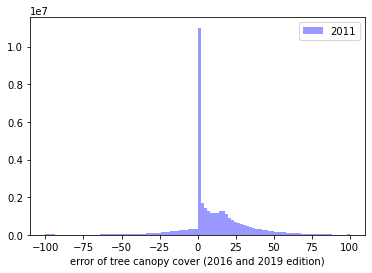

In [15]:
# plt.hist(df["error"] , color="red", label="2016 edition",alpha=0.5,bins=100)
# sns.distplot(df["error"] , color="red", label="2016 edition")
plt.hist( df["error2019"] , color="blue", label="2011",alpha=0.4,bins=100)
# sns.distplot( df["error2019"] , color="skyblue", label="2019 edition",hist_kws={'alpha':0.6})
# hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"}
plt.xlabel('error of tree canopy cover (2016 and 2019 edition)')
plt.legend()
plt.show()

### if we eliminate all the cells that their tree cover is 0 and the error is 0

In [17]:
dfNonZeros = (df.loc[((df['error2019']!=0) & (df['LC_Tree']!=0))])


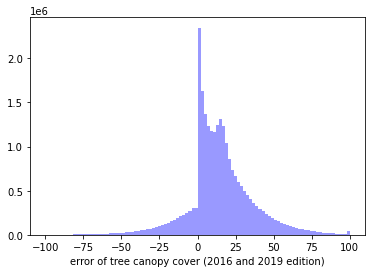

In [18]:

plt.hist( dfNonZeros["error2019"] , color="blue", label="2011",alpha=0.4,bins=100)
# sns.distplot( df["error2019"] , color="skyblue", label="2019 edition",hist_kws={'alpha':0.6})
# hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"}
plt.xlabel('error of tree canopy cover (2016 and 2019 edition)')
plt.show()

In [19]:
print ('absolute error: ',(np.abs(dfNonZeros.error2019)).mean())

absolute error:  19.423340039620555


In [20]:
# rms_NLCD2011ed = sqrt(mean_squared_error(df['LC_Tree'], df['NLCD_TC']))
rms_NLCD2016ed_nonZero = sqrt(mean_squared_error(dfNonZeros['LC_Tree'],dfNonZeros['NLCD_2019Ed']))
# print ('The RMSE score for NLCD Tree Cover 2011 (2016 edition -Version-A)',rms_NLCD2011ed)
print ('The RMSE score for NLCD Tree Cover 2011 for non-zero cells)',rms_NLCD2016ed_nonZero)

The RMSE score for NLCD Tree Cover 2011 for non-zero cells) 26.03952553621396


### SI-2 Figure 2 Compare the error distribution of both editions
##### 0 value of error is most prevelant in areas where there is no tree. to see the varaitions with a better resolution, we can eliminate 0 and see the distribution again

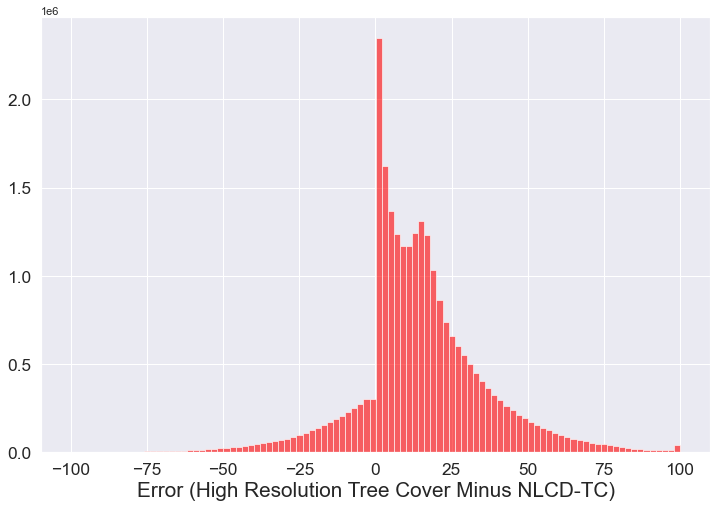

In [52]:
sns.set(rc={'figure.figsize':(12,8)})
with sns.axes_style("darkgrid",rc={'figure.figsize':(12,9)}):
    plt.hist( dfNonZeros["error2019"] ,bins=100, color="red", label="2011",alpha=0.6)
    plt.xticks(fontsize= 'x-large')
    plt.yticks(fontsize='x-large')
    plt.xlabel('Error (High Resolution Tree Cover Minus NLCD-TC)', fontsize='xx-large')
    plt.ylabel('',fontsize='xx-large')
#     plt.legend(fontsize='xx-large')
    plt.show()

## SI2-2 Figure 3 Distribution of NLCD Tree Canopy 2011; 2016 eidition (vesion-A)

###### cover 0 is removed to see the distribution more effectively

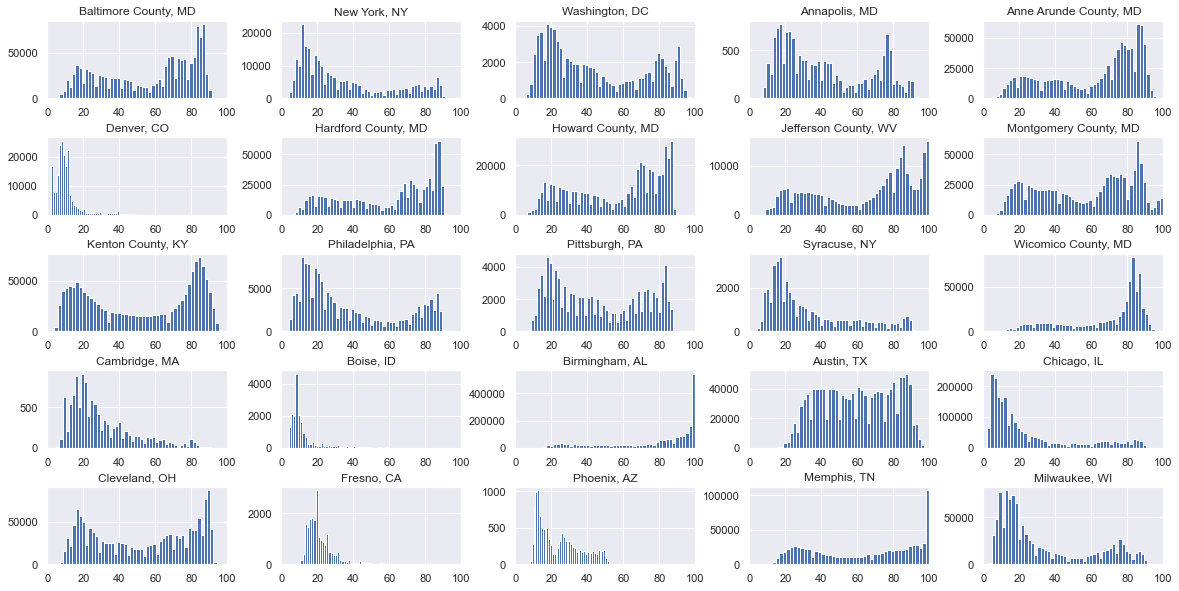

In [31]:
lstCities=df.city.unique()
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=.5)
for ax, city in zip(axs.flat, lstCities):
    # because of low tree cover in Phoenix and Boise, we changed the bin numbers of them.
    if (city=='Boise_ID' or city=='Phoenix_AZ'):
        dfme=df[(df.city==city)&(df['NLCD_TC']>0)]
        ax.hist(dfme.NLCD_TC,30)
        ax.set_title(str(city))
        #ax.set_xticks(range(0,100))
        ax.set_xlim(0,100)
    else:
        dfme=df[(df.city==city)&(df['NLCD_TC']>0)]
        ax.hist(dfme.NLCD_TC, 50)
        ax.set_title(str(city))
        #ax.set_xticks(range(0,100))
        ax.set_xlim(0,100)

## SI2-2 Figure 4 Distribution of NLCD Tree Canopy 2011; 2019 eidition (version-B)

###### cover 0 is removed to see the distribution more effectively

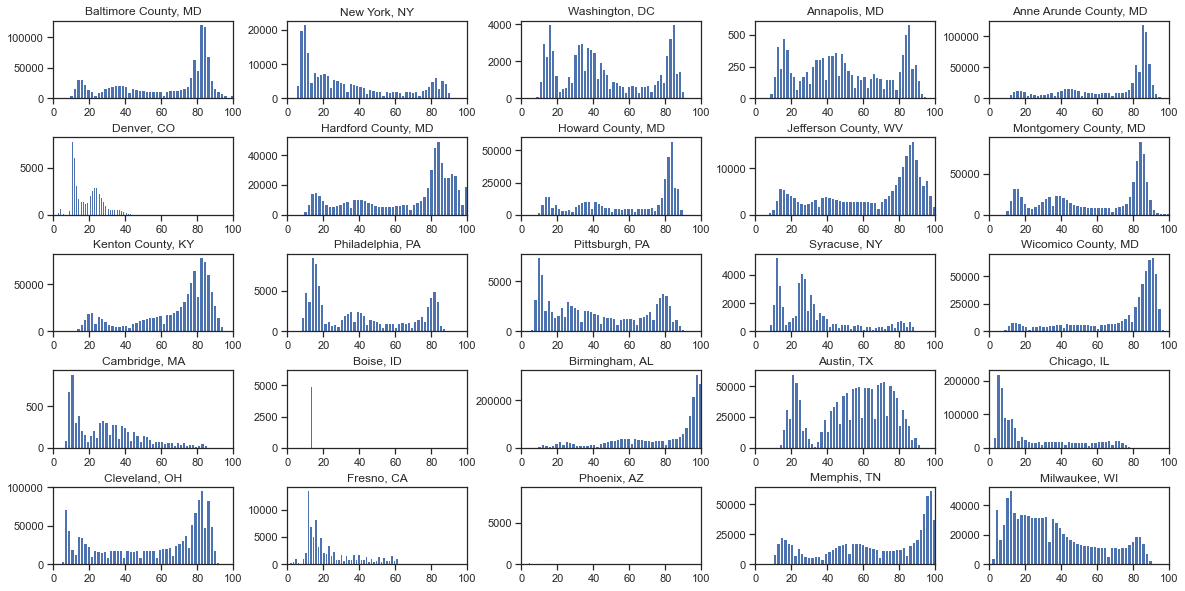

In [33]:
sns.set_style("ticks")
lstCities=df.city.unique()
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=.5)
for ax, city in zip(axs.flat, lstCities):
    # because of low tree cover in Phoenix and Boise, we changed the bin numbers of them.
    if (city=='Boise_ID' or city=='Phoenix_AZ'):
        dfme=df[(df.city==city)&(df['NLCD_2019Ed']>=0)]
        ax.hist(dfme.NLCD_2019Ed)
        ax.set_title(str(city))
        #ax.set_xticks(range(0,100))
        ax.set_xlim(0,100)
    else:
        dfme=df[(df.city==city)&(df['NLCD_2019Ed']>0)]
        ax.hist(dfme.NLCD_2019Ed,50)
        ax.set_title(str(city))
        #ax.set_xticks(range(0,100))
        ax.set_xlim(0,100)

## SI2-2 Figure 6 Distribution of error in each city for both 2016 and 2019 editions (version-A and B)

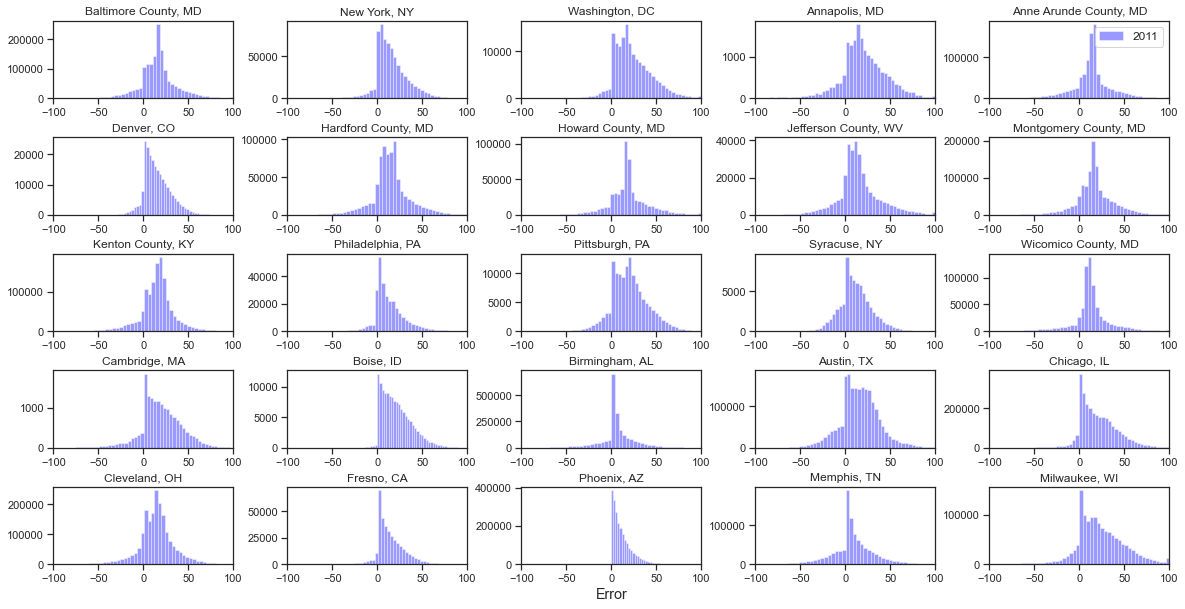

In [35]:
sns.set_style("ticks")
lstCities=dfNonZeros.city.unique()
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=.5)
for ax, city in zip(axs.flat, lstCities):
    # because of low tree cover in Phoenix and Boise, we changed the bin numbers of them.
    if (city=='Boise_ID' or city=='Phoenix_AZ'):
        # dfme=dfNonZeros[(dfNonZeros.city==city)]
        # ax.hist(dfme.error,20,color='red',alpha=0.5,label='2016 ed (Version-A)')
        dfme=dfNonZeros[(dfNonZeros.city==city)]
        ax.hist(dfme.error2019,20,color='blue',alpha=0.4,label='2011')
        ax.set_title(str(city))
        #ax.set_xticks(range(0,100))
        ax.set_xlim(-100,100)
    else:
        # dfme=dfNonZeros[(dfNonZeros.city==city)]
        # ax.hist(dfme.error,50,color='red',alpha=0.5,label='2016 ed (Version-A)')
        dfme=dfNonZeros[(dfNonZeros.city==city)]
        ax.hist(dfme.error2019,50,color='blue',alpha=0.4,label='2011')
        ax.set_title(str(city))
        #ax.set_xticks(range(0,100))
        ax.set_xlim(-100,100)
axs[0,4].legend(loc='upper right',prop={'size': 12})
axs[4,2].set_xlabel('Error',{'fontsize':'large'});

### Histograms of 9 cities only

In [16]:
lst9Cities=np.array(['Baltimore County, MD', 'New York, NY', 'Washington, DC', 'Cleveland, OH', 'Chicago, IL', 'Austin, TX', 'Portland, OR',
                     'Boise, ID','Denver, CO'])

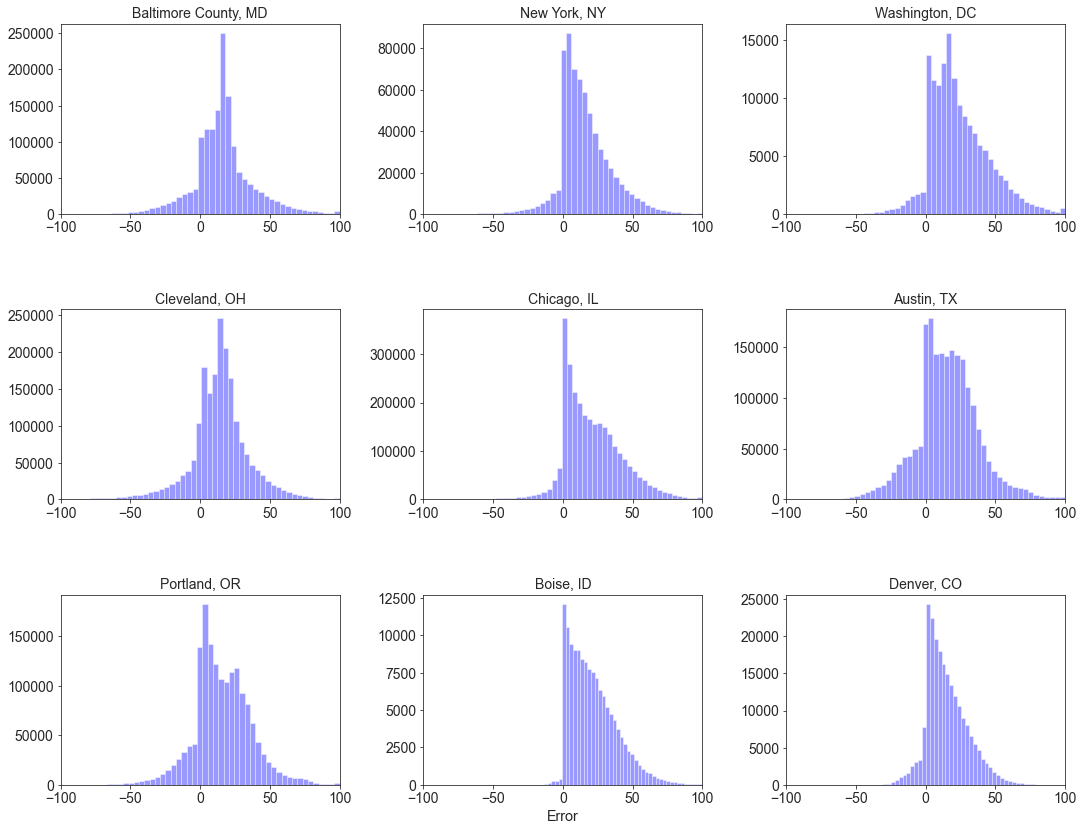

In [25]:
sns.set_style("ticks")
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
plt.subplots_adjust(wspace=0.3, hspace=.5)
for ax, city in zip(axs.flat, lst9Cities):
    # because of low tree cover in Phoenix and Boise, we changed the bin numbers of them.
    if (city=='Boise_ID' or city=='Phoenix_AZ'):
        # dfme=dfNonZeros[(dfNonZeros.city==city)]
        # ax.hist(dfme.error,20,color='red',alpha=0.5,label='2016 ed (Version-A)')
        dfme=dfNonZeros[(dfNonZeros.city==city)]
        ax.hist(dfme.error2019,10,color='blue',alpha=0.4,label='2011')
        ax.set_title(str(city),{'fontsize': 14, 'fontweight': 'medium'})
        #ax.set_xticks(range(0,100))
        ax.set_xlim(-100,100)
        ax.tick_params(axis='both', which='major', labelsize=14)

    else:
        dfme=dfNonZeros[(dfNonZeros.city==city)]
        # ax.hist(dfme.error,50,color='red',alpha=0.5,label='2016 ed (Version-A)')
        # dfme=df[(df.city==city)&(df['error2019']!=0)]
        ax.hist(dfme.error2019,50,color='blue',alpha=0.4,label='2011')
        ax.set_title(str(city),{'fontsize': 14, 'fontweight': 'medium'})        #ax.set_xticks(range(0,100))
        ax.set_xlim(-100,100)
        ax.tick_params(axis='both', which='major', labelsize=14)

#axs[0,2].legend(loc='upper right',prop={'size': 12})
axs[2,1].set_xlabel('Error',{'fontsize':'x-large'});

#  (SI Section 3): Exploring the geography of NLCD-TC error

In [16]:
# this function sorts the order for boxplot
def sortForPlot (df,groupCol,sortCol):
    df3=df.groupby([groupCol]).agg({sortCol: np.median})
    df3=df3.sort_values(sortCol)
    lstOrder=df3.index
    del df3
    return lstOrder

In [17]:
def getMeanLevelsOfFactor (df,factorCol,valCol):
    for val in (df[factorCol].unique()):
        print ('The mean error of {} data is: '.format(val), np.nanmean(df.loc[(df[factorCol]==val), valCol]))

In [18]:
# this function gets the  df and calculates the mean of two cols and then returns the barchart to compare them for a categorical variable
def drawMeanBarchartComparison (df,aggVar,error16,error19):
    dfmeanError=df.groupby([aggVar], as_index=False)[error16].mean()
    dfmeanError.loc[:, 'edition'] = 'Version-A'
    dfmeanError.rename(columns={error16: 'error'}, inplace=True)
    dfmeanError2019=df.groupby([aggVar], as_index=False)[error19].mean()
    dfmeanError2019.rename(columns={error19: 'error'}, inplace=True)
    dfmeanError2019.loc[:,'edition']='Version-B'
    dfmeans = pd.concat([dfmeanError,dfmeanError2019]);
    return sns.barplot(x=aggVar, y='error', hue='edition', data=dfmeans,palette="Set1",alpha=0.8,ci=95,errcolor='.26',estimator=median,errwidth=0.2)

In [19]:
# this functions gets the average of error for a list of ranges
#  this fucntions can be used to see how error is changing in different tree cover ranges
lstRanges=[[0,5],[5,10],[10,20],[20,40],[20,60],[60,80],[80,101]]
def getMeanOfRanges (df,lstRangesArg,argVar):
    lstmeanErrors=[]
    lstAveVal=[]
    for item in lstRangesArg:
        dfDraw=df.loc[(df['LC_Tree']>=item[0])&(df['LC_Tree']<item[1])]
        lstmeanErrors.append (np.mean(dfDraw[argVar]))
        lstAveVal.append(((item[0]+item[1])/2))
    del dfDraw
    return [lstAveVal,lstmeanErrors]

## SI3-1 Error across data sources (the source of high res landcover layers; a: EPA-Enviroatlas, b: UV)

### Compare Means (2016 eidtion)

In [25]:
# print ('The error of EPA data is (2016 edition): ', (df.loc[(df.dataSource=='EPA'), 'error']).mean())
print ('The error of EPA data is (2011): ', (df.loc[(df.dataSource=='EPA'), 'error2019']).mean())

# print ('The error of UV data is: (2016 edition): ' , (df.loc[(df.dataSource=='UV'), 'error']).mean())
print ('The error of UV data is: (2011): ' , (df.loc[(df.dataSource=='UV'), 'error2019']).mean())

The error of EPA data is (2011):  9.016579308136574
The error of UV data is: (2011):  11.446781702811485


#### SI-3 Figure 7 comparison of the average error for UV and EPA data sources and for both version-A (2016 eidtion) and version-B (2019 eidtion)

### SI-3 Figure 8 boxplot

In [26]:
# prepare a separate dataframe for comparing two editions
dfa = dfNonZeros[['city','morphology','built','EcoRegions','dataSource','error']];
dfa.loc[:, 'edition'] = ' Edition 2016 (Version-A)';
dfb= df[['city','morphology','built','EcoRegions','dataSource','error2019']];
dfb.rename(columns={'error2019': 'error'}, inplace=True);
dfb.loc[:,'edition']='Edition 2019 (Version-B)';
dfc = pd.concat([dfa,dfb]);

C:\Users\mehdi\.conda\envs\UrbanDataAnalysis\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\mehdi\.conda\envs\UrbanDataAnalysis\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\mehdi\.conda\envs\UrbanDataAnalysis\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [27]:
dfc.EcoRegions.unique()

array(['8.3', '8.1', '9.4', '8.4', '8.5', '10.1', '8.2', '11.1', '10.2',
       '7.1'], dtype=object)

In [29]:
dfNonZeros.loc[dfNonZeros['dataSource']=='CitySeattle','dataSource']='UV'

Text(0.5, 0, 'Error in Data Sources')

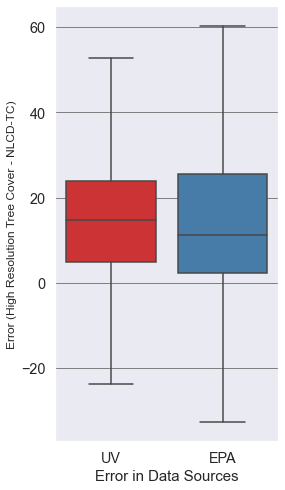

In [57]:
sns.set(rc={'figure.figsize':(4,8)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(4,8)})

p1=sns.boxplot(x="dataSource", y="error2019", data=dfNonZeros, color="grey",showfliers=False,width=0.8)
ax=p1.axes
ax.tick_params(axis='x',labelrotation=0,labelsize='large' )
ax.tick_params(axis='y',labelsize='large' )
plt.ylabel('Error (High Resolution Tree Cover - NLCD-TC)',fontsize=12)
plt.xlabel('Error in Data Sources',fontsize=15)



### SI-3 Figure 9 Error across Ecoregions

### Comparing mean of ecoregions

No handles with labels found to put in legend.


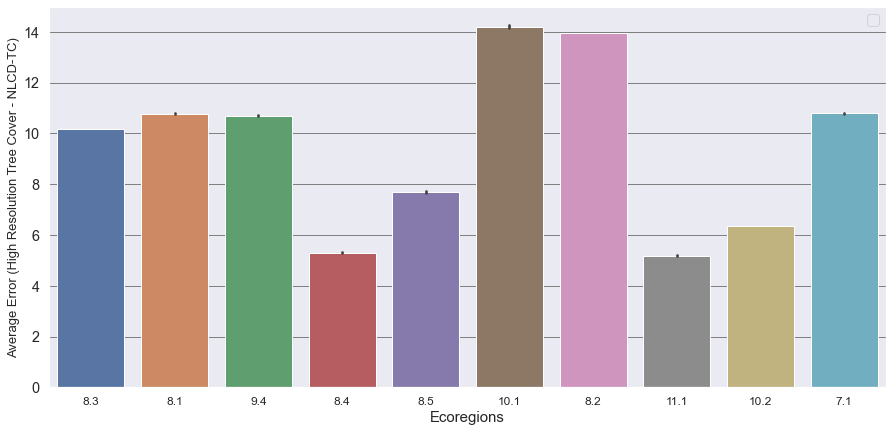

In [64]:
sns.set(rc={'figure.figsize':(15,7)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(20,7)})
p1=sns.barplot(x="EcoRegions", y="error2019", data=df,color='grey')
ax=p1.axes
ax.tick_params(axis='x',labelrotation=0,labelsize='medium' )
ax.tick_params(axis='y',labelsize='large' )
plt.ylabel('Average Error (High Resolution Tree Cover - NLCD-TC)',fontsize=13)
plt.xlabel('Ecoregions',fontsize=15)
plt.legend(loc='upper right',prop={'size': 15})

### SI-3 Figure 10 boxplot for ecoregions

#### texts on the boxplots are mean values and the lines on the boxes are median values

No handles with labels found to put in legend.


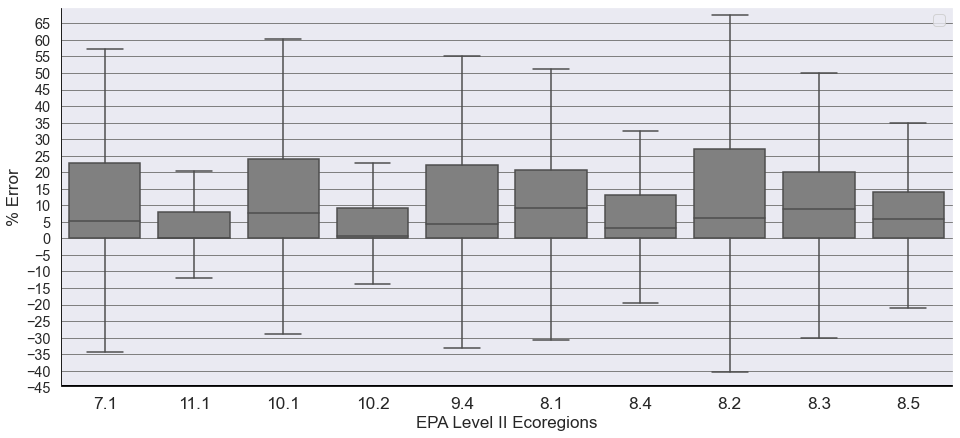

In [33]:
sns.set(rc={'figure.figsize':(16,7)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(20,7)})

p1=sns.boxplot(x="EcoRegions", y="error2019", data=df, color="grey",showfliers=False,width=0.8, 
              order=['7.1',"11.1", "10.1", "10.2",'9.4','8.1','8.4','8.2','8.3','8.5'])

ax=p1.axes
ax.tick_params(axis='x',labelrotation=0,labelsize='x-large' )
ax.tick_params(axis='y',labelsize='large' )
plt.ylabel('% Error',fontsize=17)
plt.xlabel('EPA Level II Ecoregions',fontsize=17)
# plt.xlim(-0.5,1.5)
plt.ylim(-40,70)
plt.xlim(-0.5,9.5)
plt.yticks(np.arange(-45,70,5))
plt.legend(loc='upper right',prop={'size': 15})

ax.axhline(linewidth=2, color="black",y=-44.7)
ax.axvline(linewidth=2, color="black",x=-0.485);

### SI-3 Figure 11 Error in built vs undeveloped areas

No handles with labels found to put in legend.


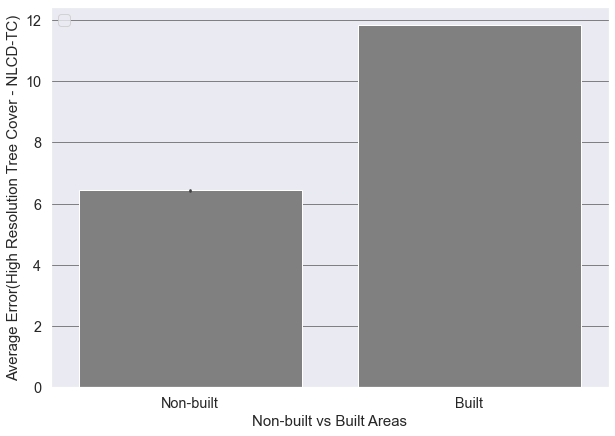

In [54]:
sns.set(rc={'figure.figsize':(10,7)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(6,5)})
p1=sns.barplot(x="built", y="error2019", data=df, color='grey')
ax=p1.axes
ax.tick_params(axis='x',labelrotation=0,labelsize='large' )
ax.tick_params(axis='y',labelsize='large' )
plt.ylabel('Average Error(High Resolution Tree Cover - NLCD-TC)',fontsize=15)
plt.xticks([0,1],['Non-built','Built'])
plt.xlabel('Non-built vs Built Areas',fontsize=15)
plt.legend(loc='upper left',prop={'size': 15})

### SI-3 Figure 12 Error in built vs undeveloped areas

#### texts on the boxplots are mean values and the lines on the boxes are median values

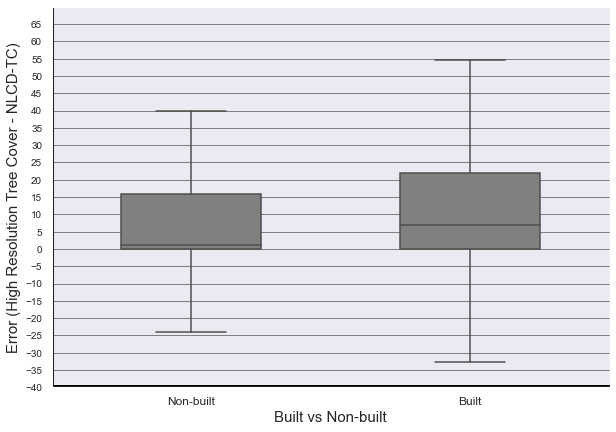

In [53]:
sns.set(rc={'figure.figsize':(10,7)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(10,7)})

p1=sns.boxplot(x="built", y="error2019", data=df, color="grey",showfliers=False,width=0.5)
ax=p1.axes
ax.tick_params(axis='x',labelrotation=0,labelsize='medium' )
ax.tick_params(axis='y',labelsize='small' )
plt.xticks([0,1],['Non-built','Built'])
plt.ylabel('Error (High Resolution Tree Cover - NLCD-TC)',fontsize=15)
plt.xlabel('Built vs Non-built',fontsize=15)
plt.xlim(-0.5,1.5)
plt.ylim(-40,70)
plt.yticks(np.arange(-40,70,5))

ax.axhline(linewidth=2, color="black",y=-39.7)
ax.axvline(linewidth=2, color="black",x=-0.495);
#plt.savefig("output.png") # Save that figure

# means = dfa.groupby(['built'])['error'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     p1.text(pos[tick]-0.12, means[tick] + 0.5, mean_labels[tick], 
#             horizontalalignment='center', size='medium', color='w', weight='semibold')

# means2 = dfb.groupby(['built'])['error'].mean().values
# mean_labels2 = [str(np.round(s, 2)) for s in means2]
# pos = range(len(means2))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     p1.text(pos[tick]+0.12, means2[tick] + 0.5, mean_labels2[tick], 
#             horizontalalignment='center', size='medium', color='w', weight='semibold')

## SI-3 Figure 13 Error in urban density gradiants

### mean of error in density gradiant categories

In [14]:
print ('The error of morphology non-built data is: ', (df.loc[(df.morphology==0), 'error2019']).mean())
print ('The error of morphology suburbs data is: ', (df.loc[(df.morphology==1), 'error2019']).mean())
print ('The error of morphology urban fringe data is: ', (df.loc[(df.morphology==2), 'error2019']).mean())
print ('The error of morphology low density data is: ', (df.loc[(df.morphology==3), 'error2019']).mean())
print ('The error of morphology med density data is: ', (df.loc[(df.morphology==4), 'error2019']).mean())
print ('The error of morphology high density data is: ', (df.loc[(df.morphology==5), 'error2019']).mean())

The error of morphology non-built data is:  6.499827920898509
The error of morphology suburbs data is:  11.043879380589207
The error of morphology urban fringe data is:  12.333261644972538
The error of morphology low density data is:  13.443293245403357
The error of morphology med density data is:  15.288118579188344
The error of morphology high density data is:  13.974157652095382


No handles with labels found to put in legend.


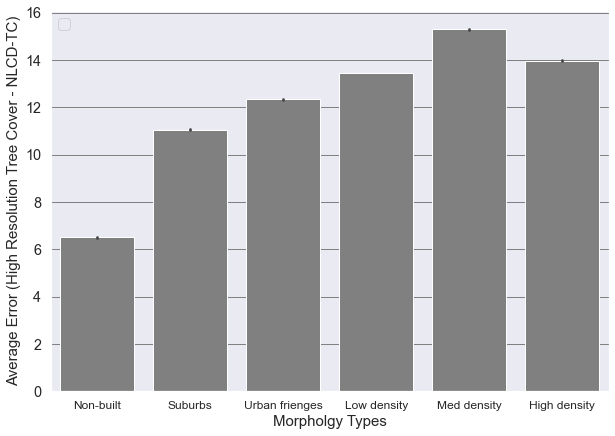

In [52]:
sns.set(rc={'figure.figsize':(10,7)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(10,7)})

p1=sns.barplot(x="morphology", y="error2019", data=df,color = 'grey')
ax=p1.axes
ax.tick_params(axis='x',labelrotation=0,labelsize='large' )
ax.tick_params(axis='y',labelsize='large' )
plt.ylabel('Average Error (High Resolution Tree Cover - NLCD-TC)',fontsize=15)
plt.xticks([0,1,2,3,4,5], ['Non-built','Suburbs','Urban frienges','Low density','Med density','High density'],fontsize=12)
plt.xlabel('Morpholgy Types',fontsize=15)
plt.legend(loc='upper left',prop={'size': 15})

## SI-3 Figure 14 Error in urban density gradiants
#### boxplot:  texts on the boxplots are mean values and the lines on the boxes are median values

### across cities

Text(0, 0.5, 'Error')

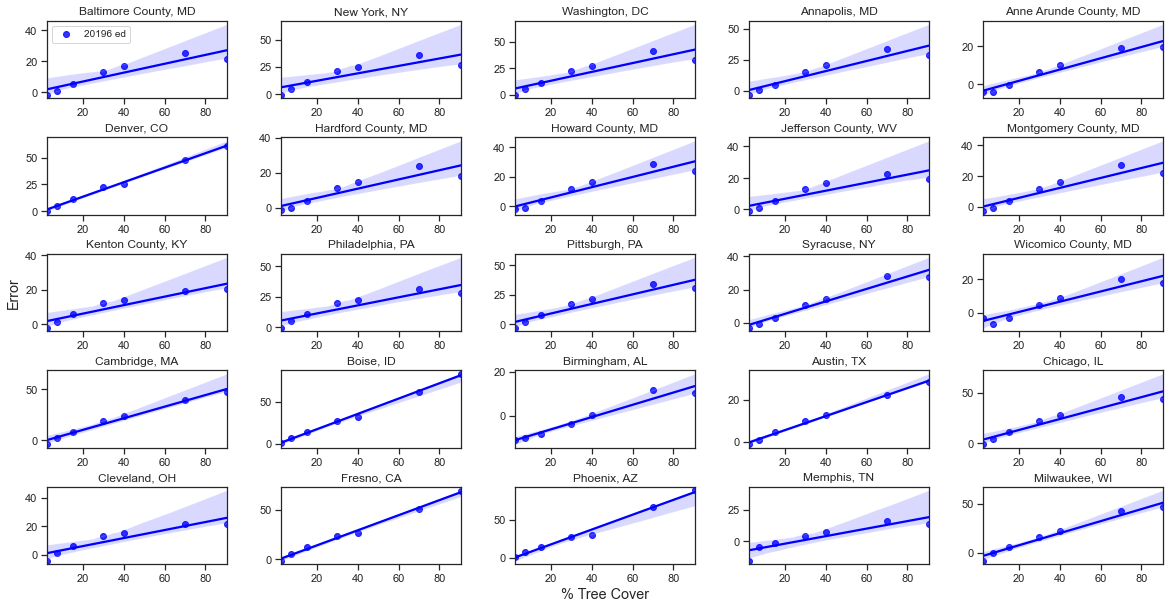

In [39]:
sns.set_style("ticks")
lstCities=df.city.unique()
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=.5)
for ax, city in zip(axs.flat, lstCities):
    dfme=df[(df.city==city)]
#     xy=getMeanOfRanges(dfme,lstRanges,'error')
#     sns.regplot(x=xy[0],y=xy[1],fit_reg=True,ax=ax,color='red',label='2016 ed')
    xy=getMeanOfRanges(dfme,lstRanges,'error2019')
    sns.regplot(x=xy[0],y=xy[1],fit_reg=True,ax=ax,color='blue',label='20196 ed')
    ax.set_title(str(city))
axs[0,0].legend(loc='upper left',prop={'size': 10})
axs[4,2].set_xlabel('% Tree Cover',{'fontsize':'large'})
axs[2,0].set_ylabel('Error',{'fontsize':'large'})

In [42]:
df9Cities=df[(df['city']=='Denver_CO') | (df['city']=='BaltimoreCounty')|(df['city']=='Portland_OR')|
              (df['city']=='Boise_ID')|(df['city']=='Chicago')|(df['city']=='NewYork')|(df['city']=='DC')|
              (df['city']=='Austin_TX')|(df['city']=='clevland_OH')|(df['city']=='Fresno_CA')]

Text(0, 0.5, 'Error')

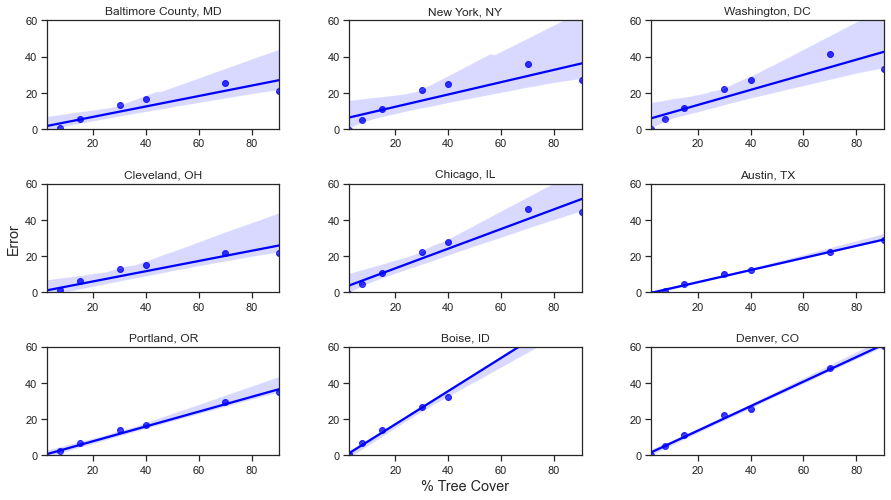

In [49]:
sns.set_style("ticks")
#lstCities=df9Cities.city.unique()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
plt.subplots_adjust(wspace=0.3, hspace=.5)
for ax, city in zip(axs.flat, lst9Cities):
    dfme=df[(df.city==city)]
#     xy=getMeanOfRanges(dfme,lstRanges,'error')
#     sns.regplot(x=xy[0],y=xy[1],fit_reg=True,ax=ax,color='red',label='Version-A')
    xy=getMeanOfRanges(dfme,lstRanges,'error2019')
    a=sns.regplot(x=xy[0],y=xy[1],fit_reg=True,ax=ax,color='blue')
    ax.set_title(str(city))
    a.set(ylim=(0, 60))
axs[2,1].set_xlabel('% Tree Cover',{'fontsize':'large'})
axs[1,0].set_ylabel('Error',{'fontsize':'large'})

## SI-3 Figure 16 Error across cities/counties
### Means of error for each city

In [ ]:
sns.set(rc={'figure.figsize':(20,7)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(20,7)})
p1 = sns.barplot(x="city", y="error2019", data=df)
ax=p1.axes
ax.tick_params(axis='x',labelrotation=90,labelsize='large' )
ax.tick_params(axis='y',labelsize='large' )
plt.ylabel('Average Error(High Resolution Tree Cover - NLCD-TC)',fontsize=15)
plt.xlabel('Cities/Counties',fontsize=15)
plt.legend(loc='upper left',prop={'size': 15});

### SI-3 Figure 17 Error across cities/counties
#### Boxplots

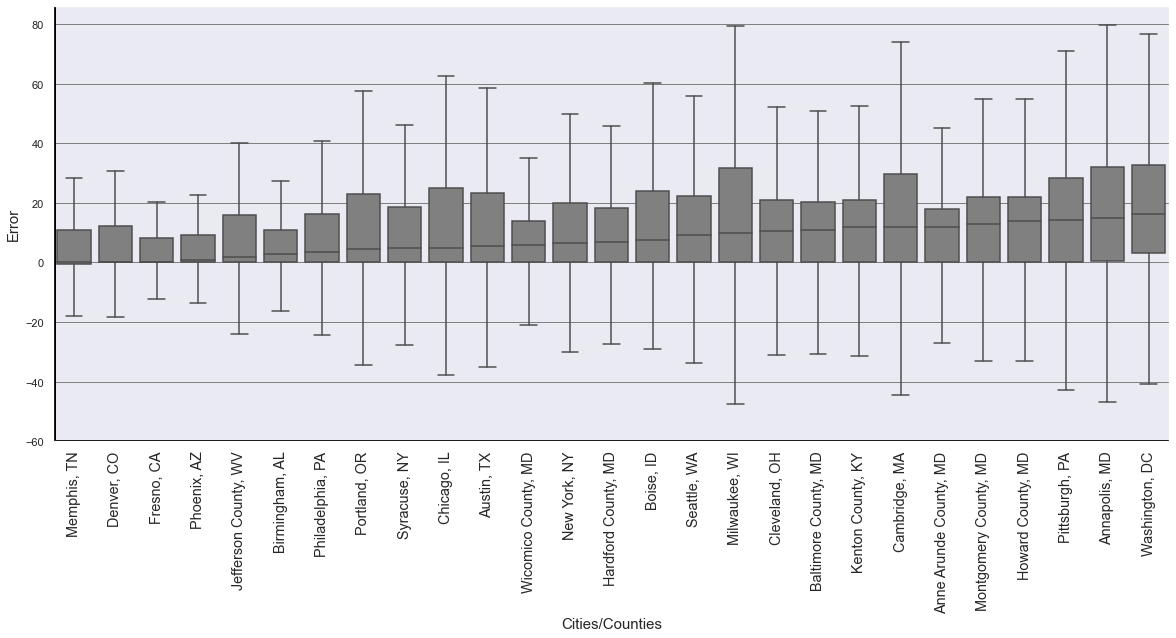

In [23]:
sns.set(rc={'figure.figsize':(20,8)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.gca().xaxis.grid(True)
lstOrder=sortForPlot(df,'city','error2019')

p1=sns.boxplot(x="city", y="error2019", data=df, color="grey",order=lstOrder,showfliers=False)

ax=p1.axes
fig=p1.figbox
ax.tick_params(axis='x',labelrotation=90,labelsize='large' )
ax.tick_params(axis='y',which='minor',grid_linewidth=.5,labelsize='x-large')
plt.xlabel('Cities/Counties',fontsize=15)
plt.ylabel('Error',fontsize=15)

plt.yticks(np.arange(-60,90,20))
ax.tick_params
ax.axhline(linewidth=2, color="black",y=-60.0)
ax.axvline(linewidth=2, color="black",x=-.45);

# means = dfa.groupby(['city'])['error'].mean().values
# mean_labels = [str(np.round(s, 2)) for s in means]
# pos = range(len(means))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     p1.text(pos[tick]-0.1, means[tick], mean_labels[tick], 
#             horizontalalignment='center', size='xx-small', color='w', weight='semibold')

# means2 = dfb.groupby(['city'])['error'].mean().values
# mean_labels2 = [str(np.round(s, 2)) for s in means2]
# pos = range(len(means2))
# for tick,label in zip(pos,ax.get_xticklabels()):
#     p1.text(pos[tick]+0.1, means2[tick], mean_labels2[tick], 
#             horizontalalignment='center', size='xx-small', color='w', weight='semibold')

## SI-3 Figure 18 error across cities/counties and density gradiants (2016 edition or version-A only)


### boxplot

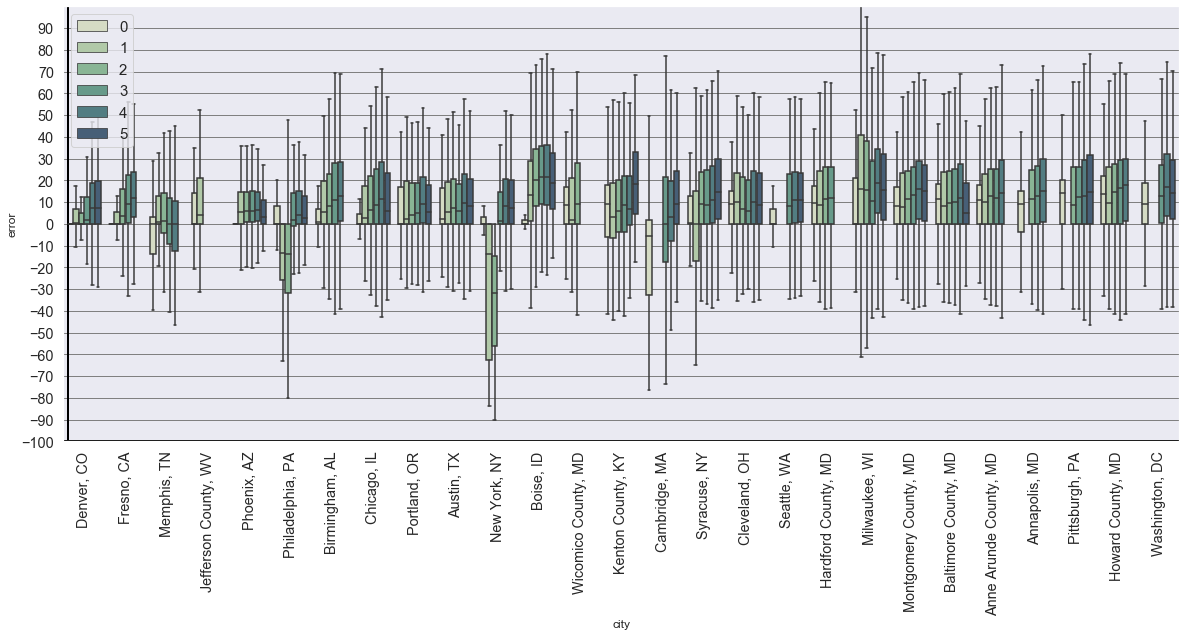

In [16]:
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
sns.set(rc={'figure.figsize':(20,8)})
lstOrder=sortForPlot(df,'city','error2019')
p1 = sns.boxplot(x="city", y="error2019",hue='morphology',order=lstOrder,
                 palette=sns.cubehelix_palette(8, start=.5, rot=-.75),data=df,showfliers=False)
ax=p1.axes
ax.tick_params(axis='x',labelrotation=90,labelsize='large' )
ax.tick_params(axis='y',labelsize='large' )
plt.ylim(-100,100)
plt.yticks(range(-100,100,10))

plt.legend(loc='upper left',prop={'size': 15})

ax.axhline(linewidth=2, color="black",y=-100)
ax.axvline(linewidth=2, color="black",x=-0.40);
#plt.savefig("output.png") # Save that figure

### SI-3 Figure 19 built vs natural areas

In [ ]:
sns.set(rc={'figure.figsize':(20,8)})
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.frameon=True
plt.gca().xaxis.grid(True)
lstOrder=sortForPlot(df,'city','error2019')
p1 = sns.boxplot(x="city", y="error2019", hue="built",
                  data=df,order=lstOrder,palette=sns.color_palette("muted"),showfliers=False)
ax=p1.axes
fig=p1.figbox
ax.tick_params(axis='x',labelrotation=90,labelsize='large' )
ax.tick_params(axis='y',labelsize='large' )
ymin=-75
ymax=100
ylim=[ymin,ymax]
plt.ylim(ymin,ymax)
plt.yticks([-70,-60,-50, -40, -30, -20, -10,   0,  10,  20,  30,  40,  50,  60,  70,80,  90, 100])
plt.legend(loc='upper left',prop={'size': 20})
ax.axhline(linewidth=2, color="black",y=-74.6)
ax.axvline(linewidth=2, color="black",x=-0.40)
#plt.savefig("output.png") # Save that figure

# Scatter plots

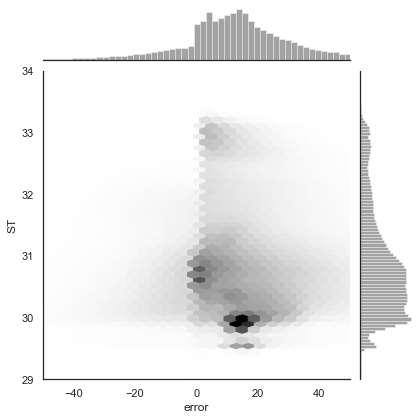

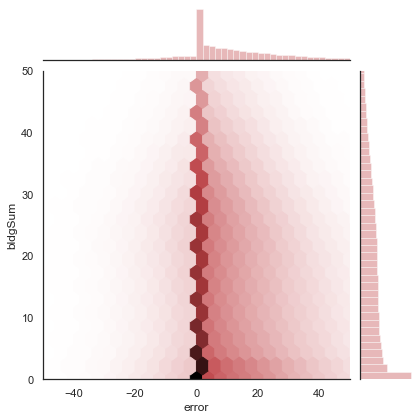

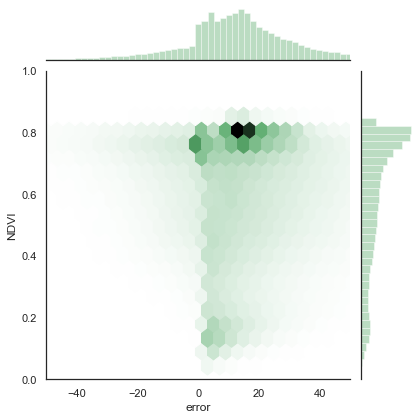

In [20]:
dfTreeOnly=df.loc[(df.LC_Tree>2) &(df.ST>29)&(df.ST<34)]
dfBuildingOnly=df.loc[df.bldgSum>0]
with sns.axes_style("white"):
    # to see your style options:
    # sns.axes_style()
    plt=sns.jointplot(x=dfTreeOnly['error2019'], y=dfTreeOnly['ST'], kind="hex", color="k",xlim=[-50,50],ylim=[29,34],marginal_kws=dict(bins=100))
    sns.jointplot(x=dfBuildingOnly['error2019'], y=dfBuildingOnly['bldgSum'], kind="hex", color="r",xlim=[-50,50],ylim=[0,50],marginal_kws=dict(bins=100))
    sns.jointplot(x=dfTreeOnly['error2019'], y=dfTreeOnly['NDVI'], kind="hex", color="g",xlim=[-50,50],ylim=[0,1],marginal_kws=dict(bins=100))
    

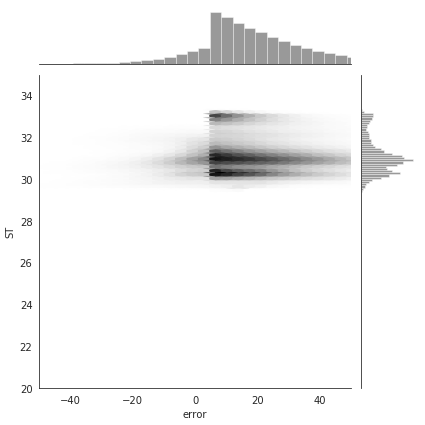

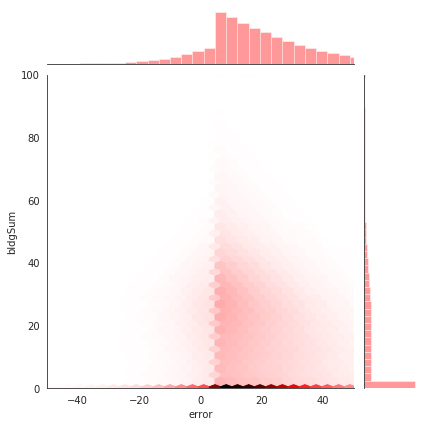

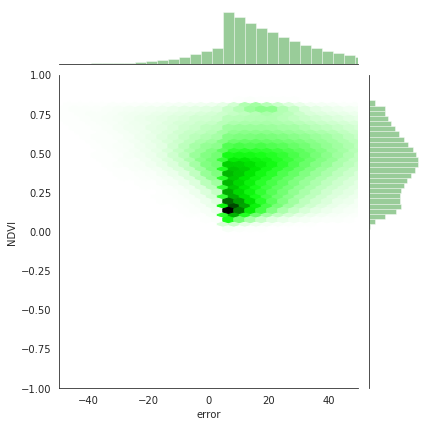

In [201]:
with sns.axes_style("white"):
    # to see your style options:
    # sns.axes_style()
    plt=sns.jointplot(x=df['error2019'], y=df['ST'], kind="hex", color="k",xlim=[-50,50],ylim=[29,35])
    sns.jointplot(x=df['error2019'], y=df['bldgSum'], kind="hex", color="r",xlim=[-50,50],ylim=[0,60])
    sns.jointplot(x=df['error2019'], y=df['NDVI'], kind="hex", color="g",xlim=[-50,50],ylim=[0,1])

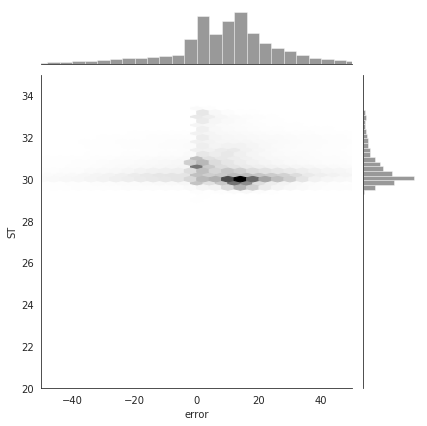

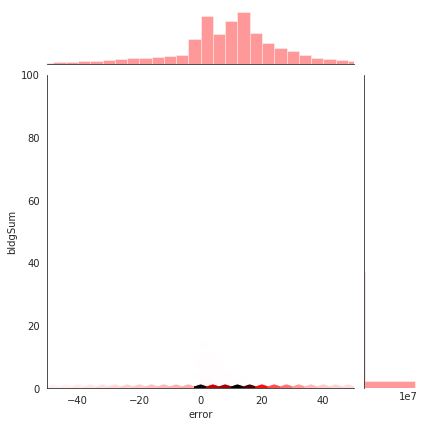

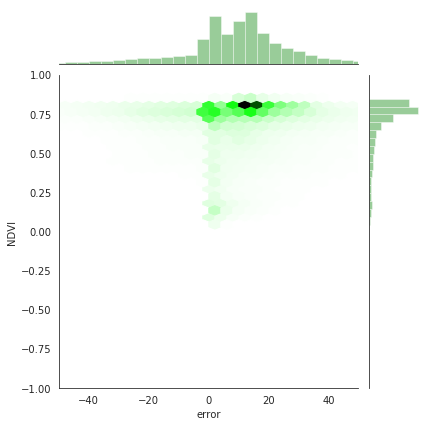

In [120]:
with sns.axes_style("white"):
    # to see your style options:
    # sns.axes_style()
    plt=sns.jointplot(x=dfNature['error2019'], y=dfNature['ST'], kind="hex", color="k",xlim=[-50,50],ylim=[20,35])
    sns.jointplot(x=dfNature['error2019'], y=dfNature['bldgSum'], kind="hex", color="r",xlim=[-50,50],ylim=[0,100])
    sns.jointplot(x=dfNature['error2019'], y=dfNature['NDVI'], kind="hex", color="g",xlim=[-50,50],ylim=[-1,1])

Text(0,1,'how erorr is distributed by morphology')

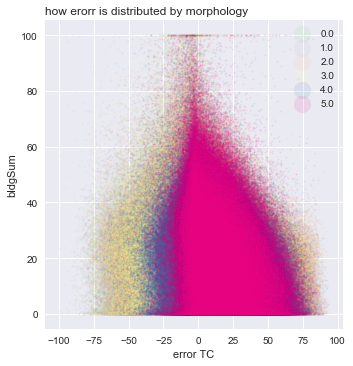

In [40]:
sns.lmplot( x='error2019', y='bldgSum', data=df, fit_reg=False, hue='morphology', legend=False, palette="Accent", scatter_kws={"alpha":0.1,"s":3} )
 
# Legend
plt.legend(loc='upper right', markerscale=10)
 
# titles
plt.xlabel('error TC')
plt.ylabel('bldgSum')
plt.title('how erorr is distributed by morphology', loc='left')


# SI-4 Predictive Models

# 27 cities: Randomforest

In [25]:
train, test = train_test_split(df,test_size=0.60)


In [26]:
len(train)

13922691

In [ ]:
# split the dataset to train and test
train, test = train_test_split(df,test_size=0.15)
# define the features
features=['morphology','NLCD_LC','bldgSum','ST','NDVI', 'AvePrecip',
          'MedianYear','AveHighTemp','built','NLCD_TC']
# define the train dataset
x_train = train[features]
y_train = train['LC_Tree']
# define the test dataset
x_test = test[features]
y_test = test['LC_Tree']

# instanciate the regressor object
regressor = RandomForestRegressor(n_estimators=300,min_samples_split=10000,
                                       max_depth=7, random_state=0)
# run the regression
regressor.fit(x_train, y_train)
y_predict=regressor.predict(x_test)

# Return the feature importances
f=regressor.feature_importances_

# Returns the coefficient of determination R^2 of the prediction.
r2=regressor.score(x_test, y_test)

# 27 cities: Decision Tree Regression

In [27]:
# split the dataset to train and test
train, test = train_test_split(df,test_size=0.15)
# define the features
features=['morphology','NLCD_LC','bldgSum','ST','NDVI', 'AvePrecip',
          'MedianYear','AveHighTemp','built','NLCD_2019Ed']
# define the train dataset
x_train = train[features]
y_train = train['LC_Tree']
# define the test dataset
x_test = test[features]
y_test = test['LC_Tree']

# instanciate the regressor object
regressor = tree.DecisionTreeRegressor(random_state = 0,min_samples_split=10000)
# run the regression
regressor.fit(x_train, y_train)
y_predict=regressor.predict(x_test)

# Return the feature importances
f=regressor.feature_importances_

# Returns the coefficient of determination R^2 of the prediction.
r2=regressor.score(x_test, y_test)

In [67]:
# printing the results of the regression
print ('R^2 of the prediction is {0}'.format(r2))
for i in range(0,len(f)):
    print ('The importance of ', features[i],'-------',round(f[i],3))

R^2 of the prediction is 0.7674993411870197
The importance of  morphology ------- 0.003
The importance of  NLCD_LC ------- 0.026
The importance of  bldgSum ------- 0.008
The importance of  ST ------- 0.003
The importance of  NDVI ------- 0.014
The importance of  AvePrecip ------- 0.014
The importance of  MedianYear ------- 0.004
The importance of  AveHighTemp ------- 0.009
The importance of  built ------- 0.002
The importance of  NLCD_2019Ed ------- 0.917


#### create a loop for multiple runs of DT model

In [63]:
lst_fraction = [0.001, 0.002,0.004,0.008, 0.01, 0.02, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
lst_r2s=[]

for fraction in lst_fraction:
    try:
        dfSampled = df.sample(frac=fraction)
        # split the dataset to train and test
        train, test = train_test_split(dfSampled,test_size=0.2)
        # define the features
        features=['morphology','NLCD_LC','bldgSum','ST','NDVI', 'AvePrecip',
                  'MedianYear','AveHighTemp','built','NLCD_2019Ed']
        # define the train dataset
        x_train = train[features]
        y_train = train['LC_Tree']
        # define the test dataset
        x_test = test[features]
        y_test = test['LC_Tree']

        # instanciate the regressor object
        regressor = tree.DecisionTreeRegressor(random_state = 0,min_samples_split=10000)
        # run the regression
        regressor.fit(x_train, y_train)
        y_predict=regressor.predict(x_test)

        # Return the feature importances
        f=regressor.feature_importances_

        # Returns the coefficient of determination R^2 of the prediction.
        r2=regressor.score(x_test, y_test)
        lst_r2s.append(r2)
        print(fraction,r2)
    except:
        print('got an error on ',fraction)

0.001 0.6398954968681101
0.002 0.6950055899436522
0.004 0.7176252913981225
0.008 0.7276942443007466
0.01 0.72763256481543
0.02 0.7380374925917605
0.04 0.7499563357639338
0.07 0.7487493320125147
0.1 0.7545886161727532
0.15 0.7572633155359689
0.2 0.7583117379461759
0.3 0.7605615397316896
0.4 0.7626793033925424
0.5 0.7637176410271317
0.6 0.763776789426596
0.8 0.7661948432313264
1 0.767226634871734


Text(0, 0.5, 'Model Performance')

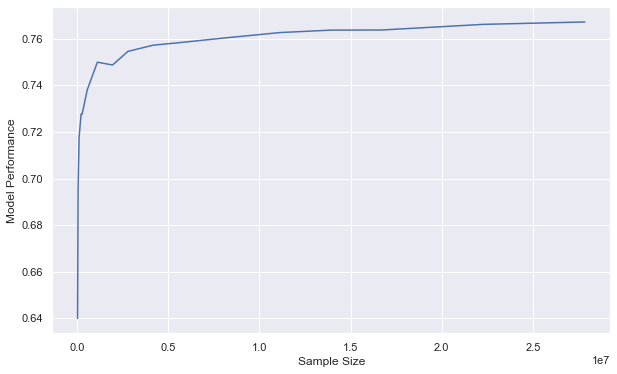

In [76]:
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot( x=np.array(lst_fraction)*0.8*len(df), y=lst_r2s)
plt.xlabel('Sample Size')
plt.ylabel('Model Performance')

### eliminate NLCD-TC to see what happens?

In [68]:
# split the dataset to train and test
train, test = train_test_split(df,test_size=0.15)
# define the features
features=['morphology','NLCD_LC','bldgSum','ST','NDVI', 'AvePrecip',
          'MedianYear','AveHighTemp','built']
# define the train dataset
x_train = train[features]
y_train = train['LC_Tree']
# define the test dataset
x_test = test[features]
y_test = test['LC_Tree']

# instanciate the regressor object
regressor = tree.DecisionTreeRegressor(random_state = 0,min_samples_split=10000)
# run the regression
regressor.fit(x_train, y_train)
y_predict=regressor.predict(x_test)

# Return the feature importances
f=regressor.feature_importances_

# Returns the coefficient of determination R^2 of the prediction.
r2=regressor.score(x_test, y_test)

In [69]:
# printing the results of the regression
print ('R^2 of the prediction is {0}'.format(r2))
for i in range(0,len(f)):
    print ('The importance of ', features[i],'-------',round(f[i],3))

R^2 of the prediction is 0.6820325691838134
The importance of  morphology ------- 0.012
The importance of  NLCD_LC ------- 0.365
The importance of  bldgSum ------- 0.01
The importance of  ST ------- 0.013
The importance of  NDVI ------- 0.519
The importance of  AvePrecip ------- 0.03
The importance of  MedianYear ------- 0.009
The importance of  AveHighTemp ------- 0.037
The importance of  built ------- 0.004
